### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
print df.select('year').distinct().count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12452
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[00 53 40 52 A0 5...|1995.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[08 59 08 59 B0 5...|1996.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[E0 58 B0 58 28 5...|1997.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[50 57 F0 56 A0 5...|1998.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[28 58 80 58 50 5...|1999.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+-------------

In [39]:
#Display statistics about the data

print "Number of Years: ",df.select('year').distinct().count()
print "Number of Stations: ",df.select('station').distinct().count()
#print "Num of rows with missing Elivation: ", df[df.elevation <-990].count()
print df.describe(['elevation','latitude', 'longitude','station', 'year']).show()
dfp = df[df.elevation >-999]
print dfp.describe(['elevation']).show()

Number of Years:  120
Number of Stations:  134
+-------+-----------------+-------------------+-------------------+-----------+------------------+
|summary|        elevation|           latitude|          longitude|    station|              year|
+-------+-----------------+-------------------+-------------------+-----------+------------------+
|  count|            12452|              12452|              12452|      12452|             12452|
|   mean|71.98695791840797|   37.8471865885002|-121.95879304529343|       null|1969.8911821394154|
| stddev|151.9103940790357|0.17047360691493715| 0.4685288195876208|       null|24.915930531154146|
|    min|           -999.9|            37.4833|             -123.0|US1CAAL0001|            1893.0|
|    max|           1173.2|            38.2103|          -120.8667|USW00093228|            2012.0|
+-------+-----------------+-------------------+-------------------+-----------+------------------+

None
+-------+------------------+
|summary|         elevation

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00041281')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00041281'
17 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    246.9| 37.4833|-121.8167|       PRCP|USC00041281|     0|[00 00 00 00 00 4...|1960.0|SSSBSSSB|
|    246.9| 37.4833|-121.8167|       PRCP|USC00041281|     0|[00 00 00 00 00 0...|1961.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(17, 365)

### Script for plotting yearly plots

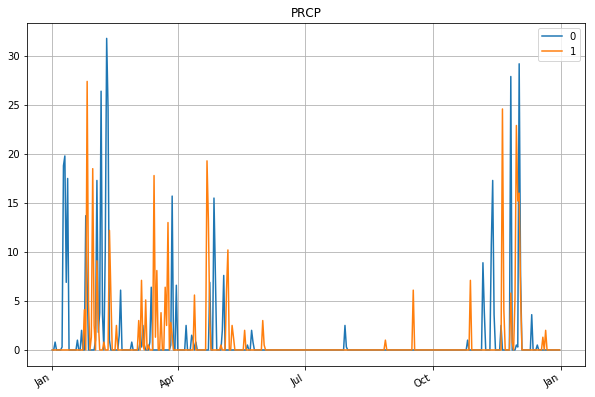

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [52]:
def plot_single(feat,func):
    j=0
    fig,X=subplots(1,1,figsize=(8,6))
    #axes=X.reshape(1)
    
    axis = X

    func(feat,fig,axis)
        
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/skenchar/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


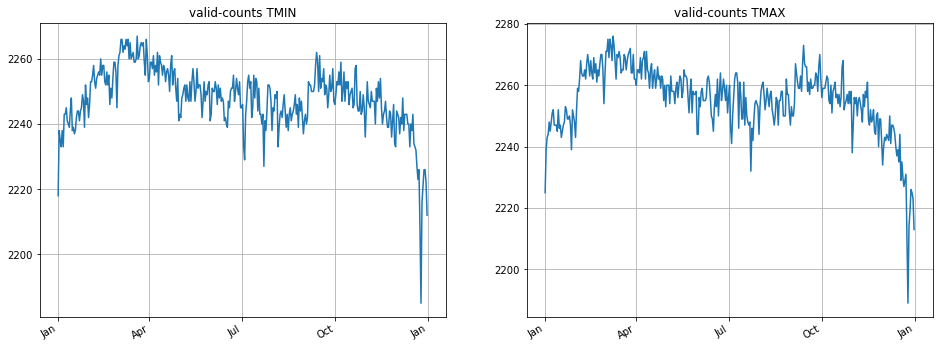

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

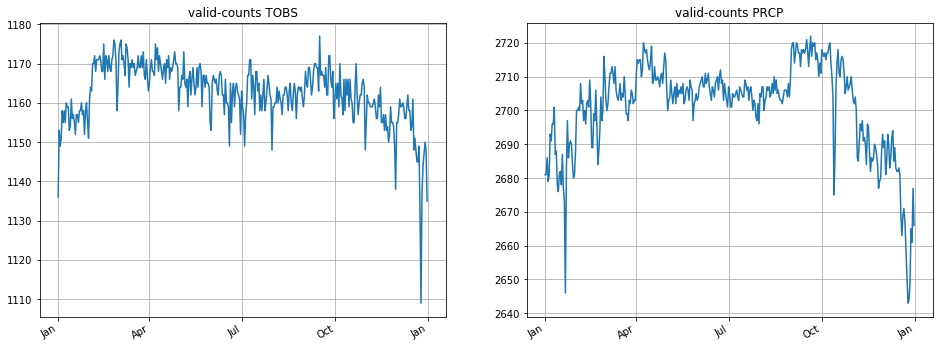

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

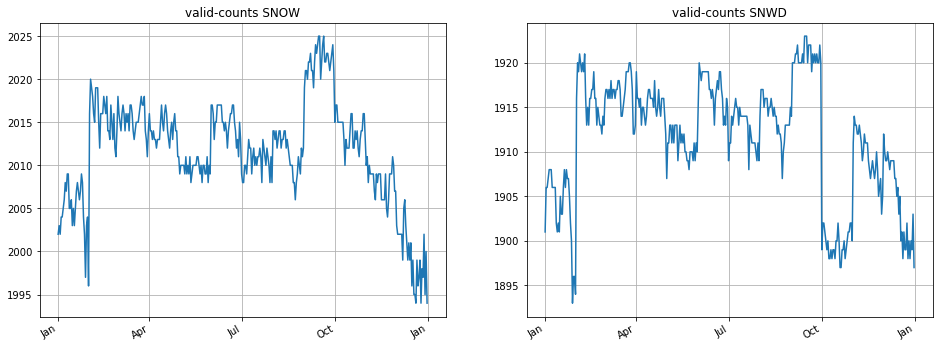

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

Axes(0.125,0.125;0.352273x0.755)
Axes(0.547727,0.2;0.352273x0.68)


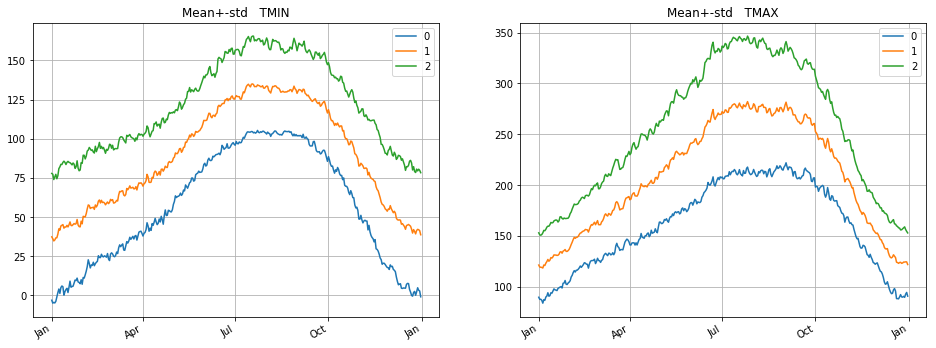

In [47]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

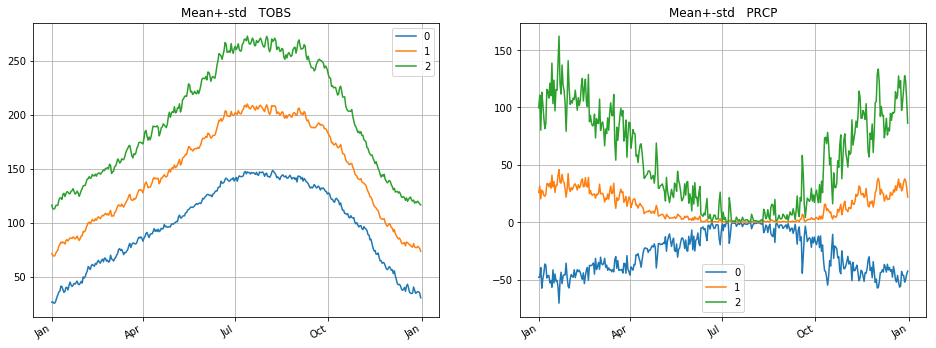

In [54]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
#plot_single('PRCP',plot_mean_std)

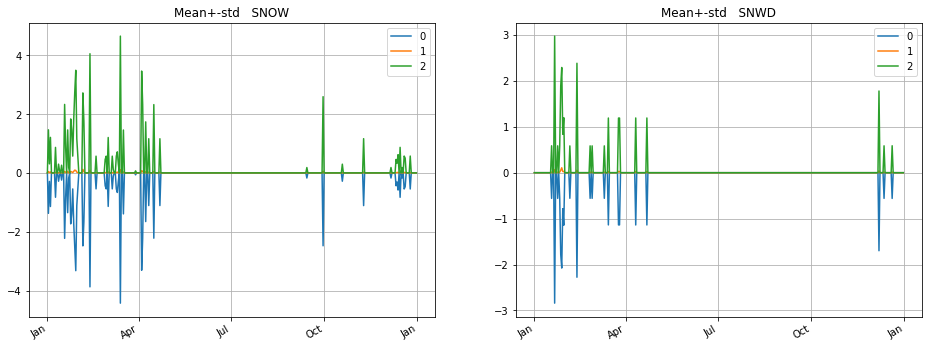

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

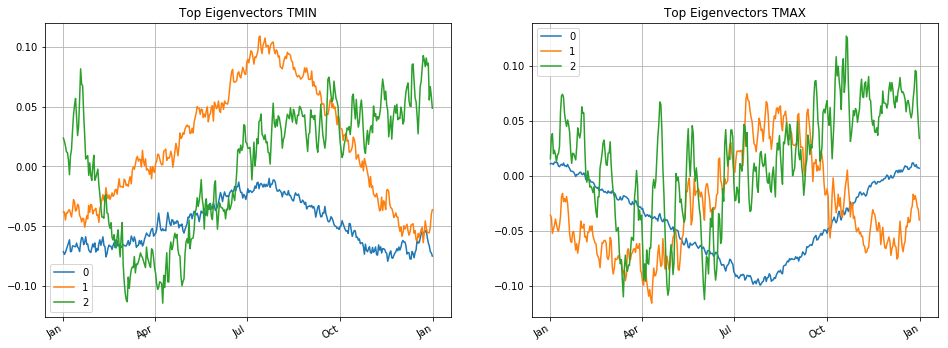

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

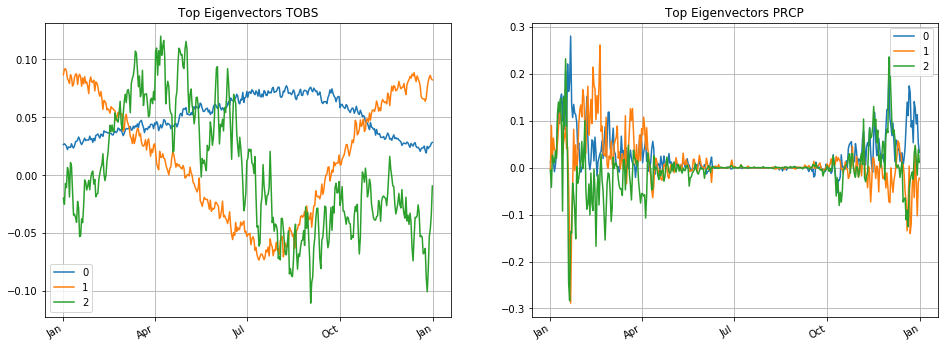

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

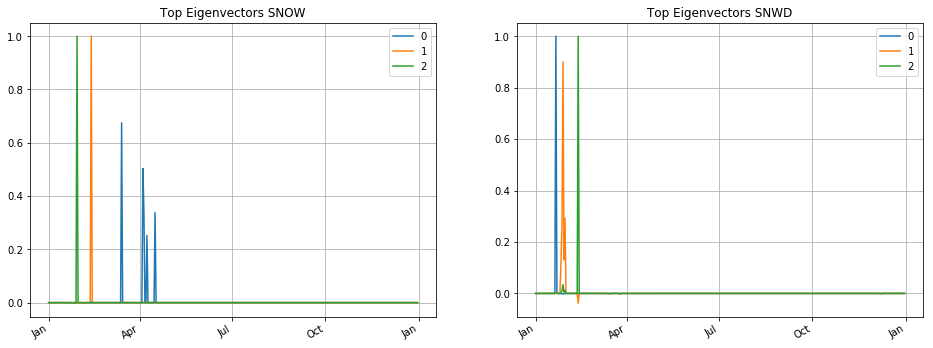

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

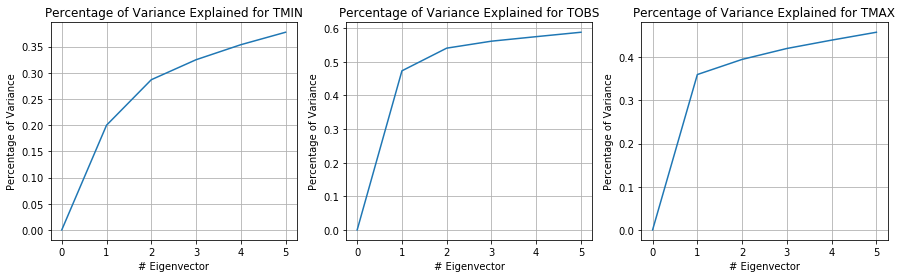

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

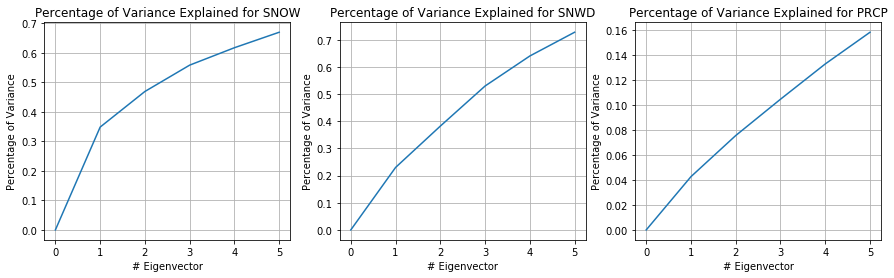

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()